In [310]:
import pandas as pd
import numpy as np

In [311]:
data = pd.read_csv("../data/stg/train/sentiments_rureviews_cleared.csv")

In [312]:
data.sentiment.value_counts()

-1    30000
 0    30000
 1    30000
Name: sentiment, dtype: int64

In [333]:
data.loc[data.sentiment == 1, "review"].iloc[12]

'прекрасные лосинки но я не попала в размер видимо станут подарком сестре'

In [113]:
from sklearn.model_selection import train_test_split

In [26]:
X = data['review']
y = data.sentiment

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, shuffle=True, random_state=17
)

In [90]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from catboost import CatBoostClassifier

In [125]:
model = make_pipeline(
    TfidfVectorizer(max_df=.3, min_df=5),
    TruncatedSVD(n_components=200,),
    CatBoostClassifier(n_estimators=500, random_state=17, verbose=0)
)

In [115]:
model.fit(X_train, y_train)

Learning rate set to 0.175574
0:	learn: 1.0361944	total: 94.9ms	remaining: 47.4s
1:	learn: 0.9920471	total: 161ms	remaining: 40.1s
2:	learn: 0.9617104	total: 219ms	remaining: 36.3s
3:	learn: 0.9354343	total: 294ms	remaining: 36.4s
4:	learn: 0.9154334	total: 349ms	remaining: 34.5s
5:	learn: 0.9005011	total: 403ms	remaining: 33.2s
6:	learn: 0.8871699	total: 461ms	remaining: 32.5s
7:	learn: 0.8753861	total: 527ms	remaining: 32.4s
8:	learn: 0.8647393	total: 588ms	remaining: 32.1s
9:	learn: 0.8557599	total: 643ms	remaining: 31.5s
10:	learn: 0.8480776	total: 709ms	remaining: 31.5s
11:	learn: 0.8411971	total: 769ms	remaining: 31.3s
12:	learn: 0.8348165	total: 826ms	remaining: 31s
13:	learn: 0.8299143	total: 878ms	remaining: 30.5s
14:	learn: 0.8254289	total: 931ms	remaining: 30.1s
15:	learn: 0.8206489	total: 997ms	remaining: 30.2s
16:	learn: 0.8162429	total: 1.05s	remaining: 29.9s
17:	learn: 0.8121970	total: 1.11s	remaining: 29.7s
18:	learn: 0.8087382	total: 1.18s	remaining: 29.8s
19:	learn: 0

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_df=0.3, min_df=5)),
                ('truncatedsvd', TruncatedSVD(n_components=200)),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7fbf298346a0>)])

In [126]:
from sklearn.model_selection import KFold, GridSearchCV

In [127]:
model.steps

[('tfidfvectorizer', TfidfVectorizer(max_df=0.3, min_df=5)),
 ('truncatedsvd', TruncatedSVD(n_components=200)),
 ('catboostclassifier', <catboost.core.CatBoostClassifier at 0x7fbf167285e0>)]

In [128]:
params = {
    "truncatedsvd__n_components": [100, 200, 300],
    "catboostclassifier__n_estimators": [200, 400, 600]
}
kf = KFold(n_splits=4, shuffle=True, random_state=7)
gcv = GridSearchCV(model, params, scoring='accuracy', n_jobs=-1, cv=kf, verbose=2)

In [129]:
gcv.fit(X_train, y_train)

Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV] END catboostclassifier__n_estimators=200, truncatedsvd__n_components=100; total time= 1.2min
[CV] END catboostclassifier__n_estimators=200, truncatedsvd__n_components=100; total time= 1.2min
[CV] END catboostclassifier__n_estimators=200, truncatedsvd__n_components=100; total time= 1.2min
[CV] END catboostclassifier__n_estimators=200, truncatedsvd__n_components=100; total time= 1.2min
[CV] END catboostclassifier__n_estimators=200, truncatedsvd__n_components=200; total time= 2.4min
[CV] END catboostclassifier__n_estimators=200, truncatedsvd__n_components=200; total time= 2.4min
[CV] END catboostclassifier__n_estimators=200, truncatedsvd__n_components=200; total time= 2.4min
[CV] END catboostclassifier__n_estimators=200, truncatedsvd__n_components=200; total time= 2.4min
[CV] END catboostclassifier__n_estimators=200, truncatedsvd__n_components=300; total time= 3.9min
[CV] END catboostclassifier__n_estimators=200, truncatedsv

GridSearchCV(cv=KFold(n_splits=4, random_state=7, shuffle=True),
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(max_df=0.3, min_df=5)),
                                       ('truncatedsvd',
                                        TruncatedSVD(n_components=200)),
                                       ('catboostclassifier',
                                        <catboost.core.CatBoostClassifier object at 0x7fbf167285e0>)]),
             n_jobs=-1,
             param_grid={'catboostclassifier__n_estimators': [200, 400, 600],
                         'truncatedsvd__n_components': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [130]:
gcv.best_score_, gcv.best_params_

(0.6894920634920635,
 {'catboostclassifier__n_estimators': 600, 'truncatedsvd__n_components': 300})

In [147]:
def get_cv_results(gcv):

    df1 = pd.DataFrame({
        "mean_score": gcv.cv_results_['mean_test_score'],
        "std_score": gcv.cv_results_['std_test_score'],
        "fit_time": gcv.cv_results_["mean_fit_time"]
    })

    df2 = pd.DataFrame(gcv.cv_results_["params"])

    return df2.join(df1)

In [148]:
get_cv_results(gcv)

,catboostclassifier__n_estimators,truncatedsvd__n_components,mean_score,std_score,fit_time
0,200,100,0.672222,0.003190,66.947149
1,200,200,0.679571,0.005601,128.909603
2,200,300,0.679698,0.004231,222.492179
3,400,100,0.680222,0.003756,197.233207
4,400,200,0.685889,0.003641,265.169511
5,400,300,0.688746,0.003360,353.327085
6,600,100,0.682921,0.003979,256.679903
7,600,200,0.688111,0.002571,326.751301
8,600,300,0.689492,0.005935,343.888586


In [149]:
model_cb = make_pipeline(
    TfidfVectorizer(max_df=.3, min_df=5),
    TruncatedSVD(n_components=200,),
    CatBoostClassifier(n_estimators=200, random_state=17, verbose=0)
)

model_cb.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_df=0.3, min_df=5)),
                ('truncatedsvd', TruncatedSVD(n_components=200)),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7fbf167289a0>)])

In [154]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [155]:
model = make_pipeline(
    TfidfVectorizer(max_df=.3, min_df=5),
    TruncatedSVD(n_components=200,),
    StandardScaler(),
    LogisticRegression(random_state=17, n_jobs=-1, C=1)
)

params = {
    "truncatedsvd__n_components": [100, 200, 300],
    "logisticregression__C": [.1, 1, 10]
}
kf = KFold(n_splits=4, shuffle=True, random_state=7)
gcv = GridSearchCV(model, params, scoring='accuracy', n_jobs=1, cv=kf, verbose=2)
gcv

GridSearchCV(cv=KFold(n_splits=4, random_state=7, shuffle=True),
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(max_df=0.3, min_df=5)),
                                       ('truncatedsvd',
                                        TruncatedSVD(n_components=200)),
                                       ('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(C=1, n_jobs=-1,
                                                           random_state=17))]),
             n_jobs=1,
             param_grid={'logisticregression__C': [0.1, 1, 10],
                         'truncatedsvd__n_components': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [156]:
gcv.fit(X_train, y_train)

Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV] END logisticregression__C=0.1, truncatedsvd__n_components=100; total time=   5.3s
[CV] END logisticregression__C=0.1, truncatedsvd__n_components=100; total time=   5.1s
[CV] END logisticregression__C=0.1, truncatedsvd__n_components=100; total time=   5.1s
[CV] END logisticregression__C=0.1, truncatedsvd__n_components=100; total time=   5.1s
[CV] END logisticregression__C=0.1, truncatedsvd__n_components=200; total time=   8.1s
[CV] END logisticregression__C=0.1, truncatedsvd__n_components=200; total time=   8.1s
[CV] END logisticregression__C=0.1, truncatedsvd__n_components=200; total time=   7.6s
[CV] END logisticregression__C=0.1, truncatedsvd__n_components=200; total time=   9.1s
[CV] END logisticregression__C=0.1, truncatedsvd__n_components=300; total time=  13.3s
[CV] END logisticregression__C=0.1, truncatedsvd__n_components=300; total time=  12.2s
[CV] END logisticregression__C=0.1, truncatedsvd__n_components=300; to

GridSearchCV(cv=KFold(n_splits=4, random_state=7, shuffle=True),
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(max_df=0.3, min_df=5)),
                                       ('truncatedsvd',
                                        TruncatedSVD(n_components=200)),
                                       ('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(C=1, n_jobs=-1,
                                                           random_state=17))]),
             n_jobs=1,
             param_grid={'logisticregression__C': [0.1, 1, 10],
                         'truncatedsvd__n_components': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [157]:
get_cv_results(gcv)

,logisticregression__C,truncatedsvd__n_components,mean_score,std_score,fit_time
0,0.1,100,0.673206,0.003862,4.843180
1,0.1,200,0.689714,0.002131,7.880864
2,0.1,300,0.697349,0.001949,11.993904
3,1.0,100,0.673984,0.003814,4.601011
4,1.0,200,0.690921,0.002954,8.348212
5,1.0,300,0.698952,0.002045,13.546391
6,10.0,100,0.675159,0.003380,5.080216
7,10.0,200,0.690571,0.002890,8.277753
8,10.0,300,0.698349,0.001844,12.654288


In [158]:
model_lr = make_pipeline(
    TfidfVectorizer(max_df=.3, min_df=5),
    TruncatedSVD(n_components=300,),
    StandardScaler(),
    LogisticRegression(random_state=17, n_jobs=-1, C=10)
)

model_lr.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_df=0.3, min_df=5)),
                ('truncatedsvd', TruncatedSVD(n_components=300)),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=10, n_jobs=-1, random_state=17))])

In [160]:
from sklearn.ensemble import RandomForestClassifier

model = make_pipeline(
    TfidfVectorizer(max_df=.3, min_df=5),
    TruncatedSVD(n_components=200,),
    RandomForestClassifier(random_state=17, n_estimators=100, n_jobs=-1)
)

params = {
    "truncatedsvd__n_components": [100, 200, 300],
    "randomforestclassifier__n_estimators": [200, 400, 600]
}
kf = KFold(n_splits=4, shuffle=True, random_state=7)
gcv = GridSearchCV(model, params, scoring='accuracy', n_jobs=1, cv=kf, verbose=2)
gcv

GridSearchCV(cv=KFold(n_splits=4, random_state=7, shuffle=True),
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(max_df=0.3, min_df=5)),
                                       ('truncatedsvd',
                                        TruncatedSVD(n_components=200)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=17))]),
             n_jobs=1,
             param_grid={'randomforestclassifier__n_estimators': [200, 400,
                                                                  600],
                         'truncatedsvd__n_components': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [161]:
gcv.fit(X_train, y_train)

Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV] END randomforestclassifier__n_estimators=200, truncatedsvd__n_components=100; total time=  23.9s
[CV] END randomforestclassifier__n_estimators=200, truncatedsvd__n_components=100; total time=  22.5s
[CV] END randomforestclassifier__n_estimators=200, truncatedsvd__n_components=100; total time=  25.7s
[CV] END randomforestclassifier__n_estimators=200, truncatedsvd__n_components=100; total time=  24.4s
[CV] END randomforestclassifier__n_estimators=200, truncatedsvd__n_components=200; total time=  34.3s
[CV] END randomforestclassifier__n_estimators=200, truncatedsvd__n_components=200; total time=  34.2s
[CV] END randomforestclassifier__n_estimators=200, truncatedsvd__n_components=200; total time=  35.5s
[CV] END randomforestclassifier__n_estimators=200, truncatedsvd__n_components=200; total time=  33.4s
[CV] END randomforestclassifier__n_estimators=200, truncatedsvd__n_components=300; total time=  41.7s
[CV] END randomforestc

GridSearchCV(cv=KFold(n_splits=4, random_state=7, shuffle=True),
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(max_df=0.3, min_df=5)),
                                       ('truncatedsvd',
                                        TruncatedSVD(n_components=200)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=17))]),
             n_jobs=1,
             param_grid={'randomforestclassifier__n_estimators': [200, 400,
                                                                  600],
                         'truncatedsvd__n_components': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [162]:
get_cv_results(gcv)

,randomforestclassifier__n_estimators,truncatedsvd__n_components,mean_score,std_score,fit_time
0,200,100,0.663683,0.002248,23.624900
1,200,200,0.666905,0.005276,33.864728
2,200,300,0.665730,0.005002,42.583262
3,400,100,0.666778,0.005173,44.216153
4,400,200,0.670079,0.004522,65.848716
5,400,300,0.670683,0.004728,87.445178
6,600,100,0.667190,0.003155,76.166902
7,600,200,0.670365,0.003747,105.267241
8,600,300,0.670762,0.005010,129.137028


In [167]:
model_rf = make_pipeline(
    TfidfVectorizer(max_df=.3, min_df=5),
    TruncatedSVD(n_components=200),
    RandomForestClassifier(random_state=17, n_estimators=400, n_jobs=-1)
)

model_rf.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_df=0.3, min_df=5)),
                ('truncatedsvd', TruncatedSVD(n_components=200)),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=400, n_jobs=-1,
                                        random_state=17))])

In [168]:
predictions_dict = {
    "catboost": model_cb.predict(X_test).flatten(),
    "logreg": model_lr.predict(X_test).flatten(),
    "rf": model_rf.predict(X_test).flatten(),
}

In [169]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [170]:
accuracies = {
    key: accuracy_score(y_test, value) 
    for key, value in predictions_dict.items()
}

In [171]:
accuracies

{'catboost': 0.6819259259259259,
 'logreg': 0.7010740740740741,
 'rf': 0.6738148148148149}

In [173]:
print(classification_report(y_test, predictions_dict['catboost']))

              precision    recall  f1-score   support

          -1       0.69      0.67      0.68      9049
           0       0.57      0.60      0.59      8990
           1       0.79      0.78      0.79      8961

    accuracy                           0.68     27000
   macro avg       0.68      0.68      0.68     27000
weighted avg       0.68      0.68      0.68     27000



In [175]:
print(classification_report(y_test, predictions_dict['logreg']))

              precision    recall  f1-score   support

          -1       0.70      0.67      0.69      9049
           0       0.59      0.63      0.61      8990
           1       0.83      0.80      0.81      8961

    accuracy                           0.70     27000
   macro avg       0.71      0.70      0.70     27000
weighted avg       0.71      0.70      0.70     27000



In [176]:
print(classification_report(y_test, predictions_dict['rf']))

              precision    recall  f1-score   support

          -1       0.70      0.63      0.66      9049
           0       0.56      0.62      0.59      8990
           1       0.77      0.77      0.77      8961

    accuracy                           0.67     27000
   macro avg       0.68      0.67      0.68     27000
weighted avg       0.68      0.67      0.68     27000



In [222]:
# Final 

model = model_lr.fit(X, y)

In [223]:
reviews = pd.read_csv("../data/stg/reviews/moscow_restoraunts.csv")

In [224]:
from src_rest.transformers.utils import clear_texts

In [225]:
reviews_sentence = (
    reviews.assign(review=lambda x: x.review.str.split('.'))
    .explode("review"))

In [226]:
reviews_sentence["review_norm"] = clear_texts(reviews_sentence.review)

/Users/17518516/Documents/projects/restorauntcheck/src/src_rest/transformers/utils.py:114: FutureWarning: The default value of regex will change from True to False in a future version.
  return texts.str.lower().str.replace(PATTERN, "")


In [227]:
reviews_sentence[['negative', 'neutral', 'positive']] = (
    model.predict_proba(reviews_sentence.review_norm)
)

reviews_sentence["sentiment"] = (
    model.predict(reviews_sentence.review_norm)
)

In [228]:
reviews_sentence.sentiment.value_counts()

 0    24992
-1     4451
 1     3056
Name: sentiment, dtype: int64

In [238]:
reviews_sentence.loc[
    reviews_sentence.sentiment == -1, "review"
].iloc[78]

' Он остался почти тем же'

In [244]:
reviews_sentence['sentiment_prob'] = (
    reviews_sentence[['negative', 'neutral', 'positive']] * np.array([-1, 0, 1])).sum(axis=1)

In [287]:
reviews_sentence['sentiment_hc'] = 0
reviews_sentence['sentiment_hc'] = reviews_sentence['sentiment_hc'].where(
    reviews_sentence['sentiment'] == 0, reviews_sentence['positive'] - reviews_sentence['negative']
)

<AxesSubplot:>

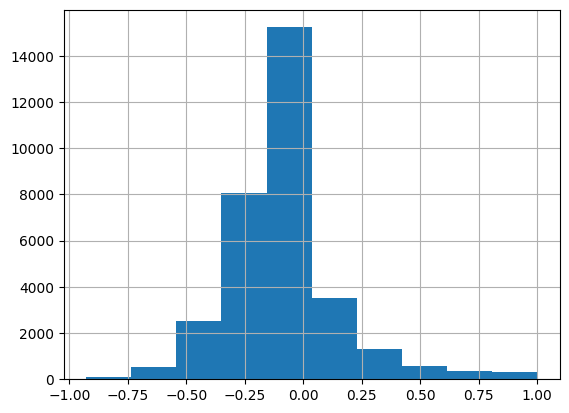

In [246]:
reviews_sentence.sentiment_prob.hist()

In [248]:
reviews_sentence.sentiment_prob.describe()

count    32499.000000
mean        -0.080135
std          0.240675
min         -0.927806
25%         -0.237219
50%         -0.065660
75%         -0.009533
max          0.999862
Name: sentiment_prob, dtype: float64

In [263]:
reviews_sentence.loc[
    reviews_sentence.sentiment_prob < -.25,
    "review"
].iloc[2988]

'Лече де Тигре, 490 ₽«Лече де Тигре» (490 руб'

In [269]:
reviews_sentence.loc[
    reviews_sentence.sentiment_prob < -.25,
    ['negative', 'neutral', 'positive']
].iloc[999]



negative    0.41490
neutral     0.42321
positive    0.16189
Name: 55, dtype: float64

In [288]:
reviews_sentence['sentiment_hc'].describe()

count    32499.000000
mean        -0.014488
std          0.213584
min         -0.927806
25%          0.000000
50%          0.000000
75%          0.000000
max          0.999862
Name: sentiment_hc, dtype: float64

In [289]:
reviews_sentence.sentiment.value_counts()

 0    24992
-1     4451
 1     3056
Name: sentiment, dtype: int64

In [309]:
reviews_sentence.loc[
    reviews_sentence.sentiment_hc > .25,
    "review"
].iloc[984]

' Кальмары мягкие, аппетитные'

In [285]:
reviews_sentence.loc[
    reviews_sentence.sentiment_hc < -.25,
    ['negative', 'neutral', 'positive']
].iloc[1399]

negative    0.41490
neutral     0.42321
positive    0.16189
Name: 140, dtype: float64

In [286]:
reviews_sentence.sentiment_hc.value_counts()

 0.000000    7507
-0.016829    2711
-0.253010    1586
-0.022551     241
-0.077840     171
             ... 
-0.113129       1
-0.133526       1
-0.164728       1
-0.219682       1
-0.127649       1
Name: sentiment_hc, Length: 15715, dtype: int64